# Interpolazione cubica

In Python l'interpolazione cubica è presente nella libreria $\verb|scipy.interpolate|$.

## Kodak Dataset

Le immagini utilizzate sono state prese dal dataset di immagini RAW Kodak (.PCD):

> https://www.math.purdue.edu/~lucier/PHOTO_CD/

In [1]:
# Loading Kodak Image Dataset

import numpy as np
import pandas
import imageio.v2 as imageio
import matplotlib.pyplot as plt

data_images = pandas.read_csv('dataset.csv')
image_list = []

for i in range(data_images.shape[0]):
    pcd_images = imageio.imread(data_images.loc[i, 'image_path'], format = 'PCD')
    image_list.append(pcd_images)

# Errori nella lettura: FILE [3], [8], [9], [16], [17], [18]

In [2]:
import numpy as np
from scipy.interpolate import griddata

def cubic_interpolation(A, m, n):
    
    grid_x, grid_y = np.meshgrid(np.linspace(0, m-1, m), np.linspace(0, n-1, n), indexing = 'ij')

    n, m = A.shape
    A = A.flatten()

    nan_indices = np.isnan(A) 
    known_indices = ~nan_indices
    known_list = np.flatnonzero(known_indices)

    kr, kc = np.unravel_index(known_list, (n, m))

    points = np.zeros([len(kr),2])
    points[:,0] = kr
    points[:,1] = kc 

    A = np.reshape(A, [n,m])
    values = A[kr,kc] 

    return griddata(points, values, (grid_x, grid_y), fill_value=0, method = 'cubic') 

## Demosaicizzazione tramite Interpolazione Cubica sul Pattern di Bayer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse, peak_signal_noise_ratio as psnr


def demosaicing_bayer(image, Red_Inpaint, Green_Inpaint, Blue_Inpaint):
    
    bayer_color = np.empty((image.shape), float)
    bayer_color[:] = np.nan
    
    bayer_color[0::2, 0::2, 0] = Red_Inpaint[0::2, 0::2]   # top left
    bayer_color[0::2, 1::2, 1] = Green_Inpaint[0::2, 1::2] # top right
    bayer_color[1::2, 0::2, 1] = Green_Inpaint[1::2, 0::2] # bottom left
    bayer_color[1::2, 1::2, 2] = Blue_Inpaint[1::2, 1::2]  # bottom right

    Gcubic = bayer_color.copy().astype(float)

    tic = time.perf_counter()
    
    for i in range(3):
        Gcubic[:, :, i] = cubic_interpolation(bayer_color[:, :, i], bayer_color.shape[0], bayer_color.shape[1])
        
    toc_cubic = time.perf_counter()
    
    cubic_process_time = toc_cubic - tic

    print('Tempo impiegato per l\'Interpolazione Cubica in secondi:', cubic_process_time)

    mse_original = mse(image, image)
    ssim_original = ssim(image, image, data_range = image.max() - image.min(), channel_axis=2)
    psnr_original = psnr(image, image)

    mse_cubic = mse(image, Gcubic)
    ssim_cubic = ssim(image, Gcubic, data_range = Gcubic.max() - Gcubic.min(), channel_axis=2)
    psnr_cubic = psnr(image, Gcubic)

#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4), sharex=True, sharey=True)
#     ax = axes.ravel()

#     ax[0].imshow(image.astype(np.uint8))
#     ax[0].set_xlabel('MSE: ' + str(round(mse_original, 2)) + '\n' + 'SSIM: ' + str(round(ssim_original, 2)) + 
#                      '\n' + 'PSNR: ' + str(round(psnr_original, 2)) )
#     ax[0].set_title('Original Image')

#     ax[1].imshow(Gcubic.astype(np.uint8))
#     ax[1].set_xlabel('MSE:' + str(round(mse_cubic, 2)) + '\n' + 'SSIM: ' + str(round(ssim_cubic, 2)) + 
#                      '\n' + 'PSNR: ' + str(round(psnr_cubic, 2)))
#     ax[1].set_title('Cubic Interpolation')
    
    plt.imshow(Gcubic.astype(np.uint8))
    plt.xlabel('MSE:' + str(round(mse_cubic, 2)) + '\n' + 'SSIM: ' + str(round(ssim_cubic, 2)) + 
                     '\n' + 'PSNR: ' + str(round(psnr_cubic, 2)))
    plt.title('Cubic Interpolation')
    
    return cubic_process_time, mse_cubic, ssim_cubic, psnr_cubic

In [2]:
# Bayer Pattern RGGB
def bayer_pattern(image):

    m,n = image[:,:,0].shape # Considero le nuove dimensioni

    Red_Inpaint = np.nan *np.ones(image[:,:,0].shape)
    Red_Inpaint[0:m-1:2, 0:n-1:2] = image[0:m-1:2, 0:n-1:2, 0]

    Green_Inpaint = np.nan *np.ones(image[:,:,1].shape)
    Green_Inpaint[0:m:2, 1:n:2] = image[0:m:2, 1:n:2, 1]
    Green_Inpaint[1:m:2, 0:n-1:2] = image[1:m:2, 0:n-1:2, 1]

    Blue_Inpaint = np.nan *np.ones(image[:,:,2].shape)
    Blue_Inpaint[1:m:2, 1:n:2] = image[1:m:2, 1:n:2, 2]
    
    cubic_process_time, mse_cubic, ssim_cubic, psnr_cubic = demosaicing_bayer(image, Red_Inpaint, Green_Inpaint, Blue_Inpaint)
    
    return cubic_process_time, mse_cubic, ssim_cubic, psnr_cubic

## Riduzione del rumore mediante Interpolazione Cubica

In [4]:
def denoising_function(image):
    
    m, n = image[:,:,0].shape
    
    G = image.astype(float) 
    G[np.random.rand(*G.shape) < 0.50] = np.nan 

    Gcubic = G.copy()
    
    tic = time.perf_counter()
    
    for i in range(3):
        Gcubic[:, :, i] = cubic_interpolation(G[:, :, i], m, n)
        
    toc_cubic = time.perf_counter()
    
    cubic_process_time = toc_cubic - tic

    print('Tempo impiegato per l\'Interpolazione Cubica in secondi:', cubic_process_time)

    mse_original = mse(image, image)
    ssim_original = ssim(image, image, data_range = image.max() - image.min(), channel_axis=2)
    psnr_original = psnr(image, image)

    mse_cubic = mse(image, Gcubic)
    ssim_cubic = ssim(image, Gcubic, data_range = Gcubic.max() - Gcubic.min(), channel_axis=2)
    psnr_cubic = psnr(image, Gcubic)
    
#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4), sharex=True, sharey=True)
#     ax = axes.ravel()

#     ax[0].imshow(image.astype(np.uint8))
#     ax[0].set_xlabel('MSE: ' + str(round(mse_original, 2)) + '\n' + 'SSIM: ' + str(round(ssim_original, 2)) + 
#                      '\n' + 'PSNR: ' + str(round(psnr_original, 2)) )
#     ax[0].set_title('Original Image')
    
#     ax[1].imshow(Gcubic.astype(np.uint8))
#     ax[1].set_xlabel('MSE:' + str(round(mse_cubic, 2)) + '\n' + 'SSIM: ' + str(round(ssim_cubic, 2)) + 
#                      '\n' + 'PSNR: ' + str(round(psnr_cubic, 2)))
#     ax[1].set_title('Cubic Interpolation')
    
    plt.imshow(Gcubic.astype(np.uint8))
    plt.xlabel('MSE:' + str(round(mse_cubic, 2)) + '\n' + 'SSIM: ' + str(round(ssim_cubic, 2)) + 
                     '\n' + 'PSNR: ' + str(round(psnr_cubic, 2)))
    plt.title('Denoising Cubic')
    
    return cubic_process_time, mse_cubic, ssim_cubic, psnr_cubic

## Test e salvataggio dei risultati

In [6]:
import pandas as pd
import os

def save_results(i, cubic_process_time, mse_cubic, ssim_cubic, psnr_cubic, folder_path):

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    csv_path = os.path.join(folder_path, 'results_cubic.csv')

    data = {
        'Image': [i+1],
        'Time Elapsed': [cubic_process_time],
        'MSE': [mse_cubic],
        'SSIM': [ssim_cubic],
        'PSNR': [psnr_cubic]
    }

    results = pd.DataFrame(data)

    if os.path.exists(csv_path):
        results.to_csv(csv_path, mode = 'a', header = False, index = False)
    else:
        results.to_csv(csv_path, mode = 'w', header = True, index = False)
        
    plt.savefig(folder_path + '/cubic_' + str(i+1) + '.png')

Tempo impiegato per l'Interpolazione Cubica in secondi: 18.408424


C:\Users\Psi\anaconda3\lib\site-packages\skimage\metrics\simple_metrics.py:163: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)
C:\Users\Psi\AppData\Local\Temp\ipykernel_5300\2711123578.py:27: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_cubic = psnr(image, Gcubic)


Tempo impiegato per l'Interpolazione Cubica in secondi: 17.857994700000003
Tempo impiegato per l'Interpolazione Cubica in secondi: 17.874443300000003
Tempo impiegato per l'Interpolazione Cubica in secondi: 17.7881068
Tempo impiegato per l'Interpolazione Cubica in secondi: 17.85212870000001
Tempo impiegato per l'Interpolazione Cubica in secondi: 17.7771465
Tempo impiegato per l'Interpolazione Cubica in secondi: 17.72354080000001
Tempo impiegato per l'Interpolazione Cubica in secondi: 17.8107052
Tempo impiegato per l'Interpolazione Cubica in secondi: 17.7871528
Tempo impiegato per l'Interpolazione Cubica in secondi: 17.953430999999995
Tempo impiegato per l'Interpolazione Cubica in secondi: 17.926440499999984
Tempo impiegato per l'Interpolazione Cubica in secondi: 17.93809730000001
Tempo impiegato per l'Interpolazione Cubica in secondi: 17.4062677
Tempo impiegato per l'Interpolazione Cubica in secondi: 17.84011509999999
Tempo impiegato per l'Interpolazione Cubica in secondi: 17.6234352999

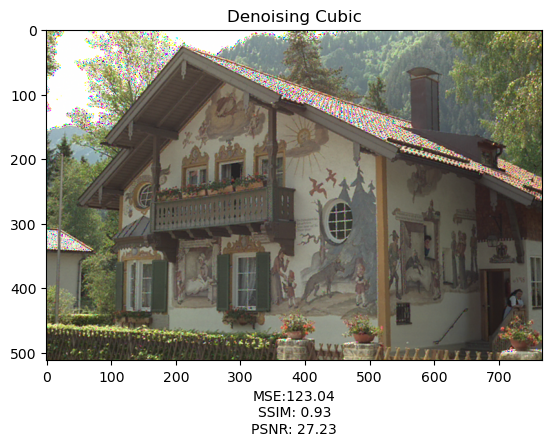

In [7]:
for i in range(len(image_list)):
    if(i in [3, 8, 9, 16, 17, 18]):
        continue
    folder_path = 'results/denoising/cubic' 
    cubic_process_time, mse_cubic, ssim_cubic, psnr_cubic = denoising_function(image_list[i])
    save_results(i, cubic_process_time, mse_cubic, ssim_cubic, psnr_cubic, folder_path)

In [8]:
import pandas as pd

df = pd.read_csv('results/denoising/cubic/results_cubic.csv')

df['Time Elapsed'] = df['Time Elapsed'].astype(float)
df['MSE'] = df['MSE'].astype(float)
df['SSIM'] = df['SSIM'].astype(float)
df['PSNR'] = df['PSNR'].astype(float)

df['Time Elapsed'] = df['Time Elapsed'].round(2)
df['MSE'] = df['MSE'].round(2)
df['SSIM'] = df['SSIM'].round(2)
df['PSNR'] = df['PSNR'].round(2)

df.to_csv('results/denoising/cubic/results_cubic_trunc.csv', index=False)